In [1]:
import jax.numpy as np
from jax import random, jit, grad, vmap
from jax.experimental import optimizers
import jax.scipy.stats.norm as norm
from jax.nn import sigmoid, log_sigmoid

import itertools
import numpy.random as npr
from tqdm import trange
from functools import partial
import matplotlib.pyplot as plt

In [2]:
class ADVI_LogisticRegression:
    def __init__(self, X, y, num_mc_samples = 50):
        # Normalize inputs
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        X = (X - self.Xmean)/self.Xstd
        # Store data
        self.X = X
        self.y = y
        # Number of MC for approximating expectations
        self.num_mc_samples = num_mc_samples
        # Initiatlize parameters of the mean-field variational family
        num_params = X.shape[1]
        init_mean = np.zeros(num_params)
        init_logstd  = np.zeros(num_params)  
        self.params = (init_mean, init_logstd)
        # Optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(1e-2)
        self.opt_state = self.opt_init(self.params)
        # Logger to monitor the loss function
        self.loss_log = []
        self.itercount = itertools.count()
    
    # Define a function to calculate the log likelihood
    def per_sample_elbo(self, params, batch, rng_key):
        X, y = batch
        mean, log_std = params
        # Sample model parameters via the re-parametrization trick
        w = mean + np.exp(log_std) * random.normal(rng_key, mean.shape)
        # Compute log_likelihood
        logit_prob = np.matmul(X, w)
        prob_pres = log_sigmoid(logit_prob)
        prob_abs = log_sigmoid(-logit_prob)
        log_likelihood = np.sum(y * prob_pres + (1 - y) * prob_abs)
        # Compute log_prior
        log_prior = np.sum(norm.logpdf(w))
        # Compute entropy of the variational posterior
        entropy = -np.sum(log_std)
        return entropy - (log_likelihood + log_prior) 

    def elbo(self, params, batch, rng_key):
        # Average over a batch of random samples.
        rng_keyes = random.split(rng_key, self.num_mc_samples)
        pe_loss = lambda key: self.per_sample_elbo(params, batch, key)
        loss = vmap(pe_loss)(rng_keyes)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        rng_key = random.PRNGKey(i)
        params = self.get_params(opt_state)
        g = grad(self.elbo)(params, batch, rng_key)
        return self.opt_update(i, g, opt_state)

    def data_stream(self, n, num_batches, batch_size):
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(n)
            for i in range(num_batches):
                batch_idx = perm[i*batch_size:(i+1)*batch_size]
                yield self.X[batch_idx, :], self.y[batch_idx]

    def train(self, num_epochs = 100, batch_size = 64):   
        n = self.X.shape[0]
        num_complete_batches, leftover = divmod(n, batch_size)
        num_batches = num_complete_batches + bool(leftover) 
        batches = self.data_stream(n, num_batches, batch_size)
        pbar = trange(num_epochs)
        for epoch in pbar:
            for _ in range(num_batches):
                batch = next(batches)
                self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            self.params = self.get_params(self.opt_state)
            loss_value = self.elbo(self.params, batch, random.PRNGKey(0))
            self.loss_log.append(loss_value)
            pbar.set_postfix({'Loss': loss_value})

In [3]:
# Generate training data
N = 1000
D = 10

key = random.PRNGKey(0)
X = random.normal(key, (N, D))
w_true = random.normal(key, (D,))
logit_true = np.matmul(X, w_true)
y = random.uniform(key, (N,)) < sigmoid(logit_true)

In [4]:
model = ADVI_LogisticRegression(X, y, num_mc_samples=20)

In [5]:
model.train(num_epochs = 2000, batch_size = 128)

100%|██████████| 2000/2000 [02:17<00:00, 14.56it/s, Loss=80.13782]


In [6]:
# Sample variational parameters
num_samples = 2000
rng_keyes = random.split(key, num_samples)
opt_params = model.get_params(model.opt_state)
mean, log_std = opt_params
sample_fn = lambda key: mean + np.exp(log_std) * random.normal(key, mean.shape)
samples = vmap(sample_fn)(rng_keyes)
mean_params = np.mean(samples, axis = 0)

Text(0, 0.5, 'ELBO loss')

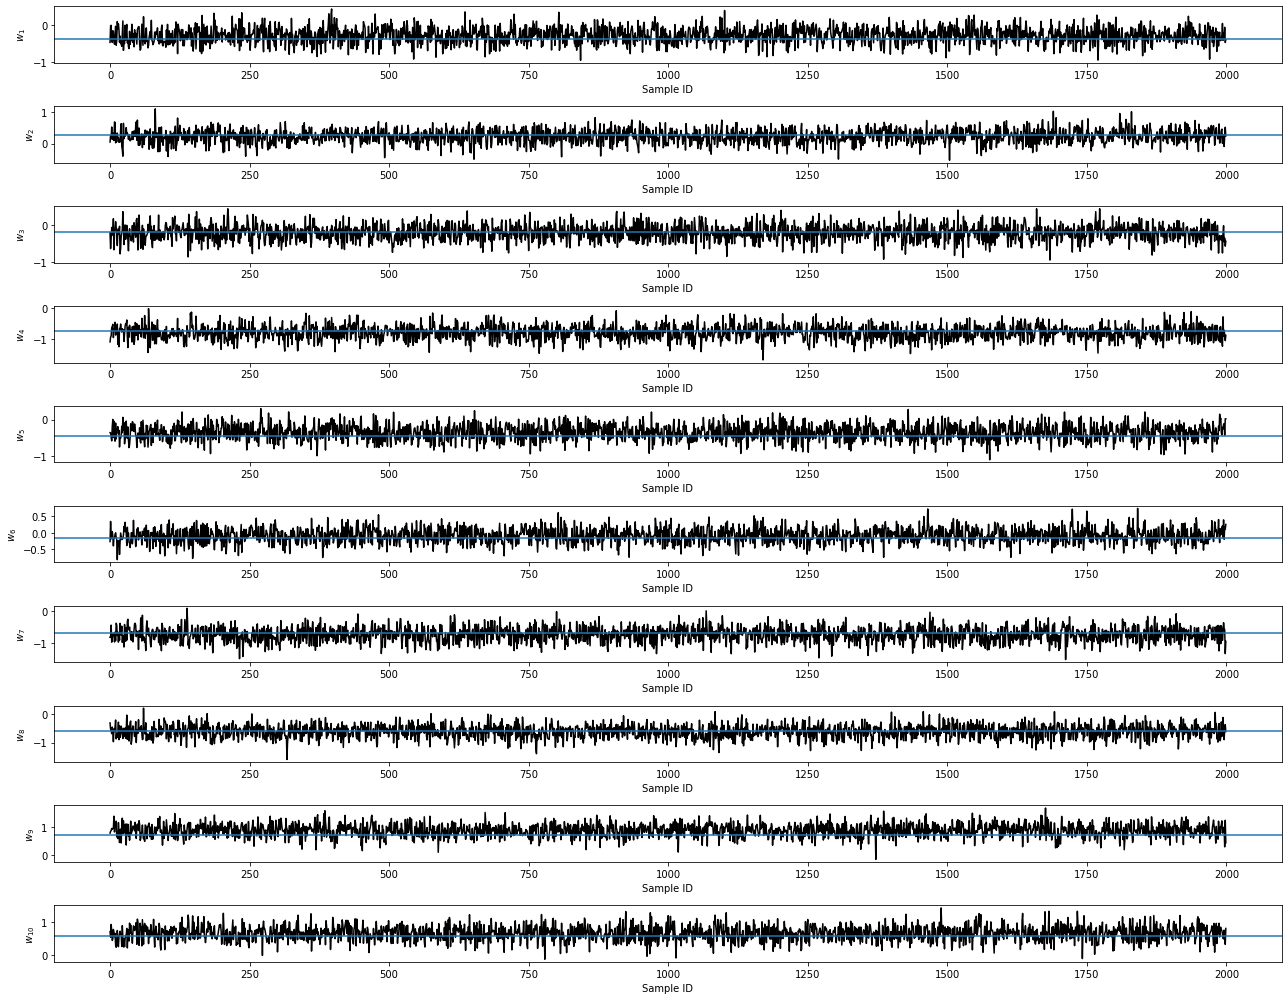

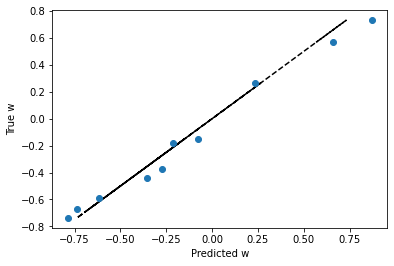

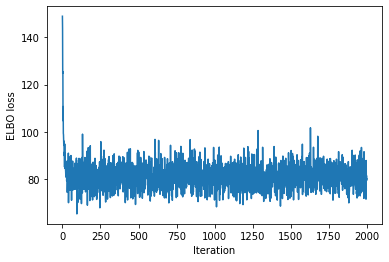

In [7]:
plt.figure(figsize = (18,14))
for i in range(samples.shape[1]):
    plt.subplot(samples.shape[1], 1, i+1)
    plt.plot(samples[:,i], 'k')
    plt.axhline(w_true[i])
    plt.xlabel('Sample ID')
    plt.ylabel('$w_{%d}$' % (i+1))
plt.tight_layout()

plt.figure()
plt.plot(w_true, w_true, 'k--')
plt.plot(mean_params, w_true, 'o')
plt.xlabel('Predicted w')
plt.ylabel('True w')

plt.figure()
plt.plot(model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('ELBO loss')